In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import statsmodels.api as sm

In [0]:
!pip install pmdarima

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
silver_trips_pdf = spark.table("`mobi-agent-data`.`mobi-agent-data-omniparent`.silver_trips").toPandas()


In [0]:
silver_trips_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5395527 entries, 0 to 5395526
Data columns (total 29 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   trip_id                       int64         
 1   departure_time                datetime64[ns]
 2   return_time                   datetime64[ns]
 3   bike                          float64       
 4   is_electric_bike              object        
 5   membership_type               object        
 6   covered_distance_m            float64       
 7   covered_distance_km           float64       
 8   duration_sec                  float64       
 9   stopover_duration_sec         float64       
 10  number_of_stopovers           float64       
 11  number_of_bike_stopovers      float64       
 12  departure_slot                float64       
 13  return_slot                   float64       
 14  lock_duration_sec             float64       
 15  number_of_bike_locks          fl

In [0]:
# Prepare Time Series DF
df_ts = silver_trips_pdf[["departure_time", "trip_id"]].copy()

# Set index with time
df_ts.set_index("departure_time", inplace=True)

In [0]:
# There are empty records
silver_trips_pdf[silver_trips_pdf["departure_time"].isna()]
# 240110 rows, trip_id 922231:2636062

,trip_id,departure_time,return_time,bike,is_electric_bike,membership_type,covered_distance_m,covered_distance_km,duration_sec,stopover_duration_sec,number_of_stopovers,number_of_bike_stopovers,departure_slot,return_slot,lock_duration_sec,number_of_bike_locks,departure_temperature_c,return_temperature_c,departure_battery_voltage_mv,return_battery_voltage_mv,departure_station_name,departure_station_id,return_station_name,return_station_id,source_file,formula,manager,departure_year,departure_month
5155101,922231,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2022_December.csv,None,None,NaN,NaN
5155102,922232,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2022_December.csv,None,None,NaN,NaN
5155103,922233,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2022_December.csv,None,None,NaN,NaN
5155104,922234,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2022_December.csv,None,None,NaN,NaN
5155105,922235,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2022_December.csv,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395206,2636058,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2023_March.csv,None,None,NaN,NaN
5395207,2636059,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2023_March.csv,None,None,NaN,NaN
5395208,2636060,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2023_March.csv,None,None,NaN,NaN
5395209,2636061,NaT,NaT,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,mobi_2023_March.csv,None,None,NaN,NaN


In [0]:
print(silver_trips_pdf[silver_trips_pdf["departure_time"].isna()].source_file.unique())
# They from between December 2022 - March 2023

silver_trips_pdf[(silver_trips_pdf["departure_time"].isna() == False) & (silver_trips_pdf["source_file"].isin([
    'mobi_2022_December.csv', 'mobi_2023_April.csv',
    'mobi_2023_February.csv', 'mobi_2023_January.csv',
    'mobi_2023_March.csv'
]))].info()

['mobi_2022_December.csv' 'mobi_2023_April.csv' 'mobi_2023_February.csv'
 'mobi_2023_January.csv' 'mobi_2023_March.csv']
<class 'pandas.core.frame.DataFrame'>
Index: 270593 entries, 2388552 to 5110865
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   trip_id                       270593 non-null  int64         
 1   departure_time                270593 non-null  datetime64[ns]
 2   return_time                   270542 non-null  datetime64[ns]
 3   bike                          0 non-null       float64       
 4   is_electric_bike              270593 non-null  object        
 5   membership_type               270416 non-null  object        
 6   covered_distance_m            270593 non-null  float64       
 7   covered_distance_km           270593 non-null  float64       
 8   duration_sec                  270593 non-null  float64       
 9   stopover_duration_sec   

<Axes: xlabel='departure_time'>

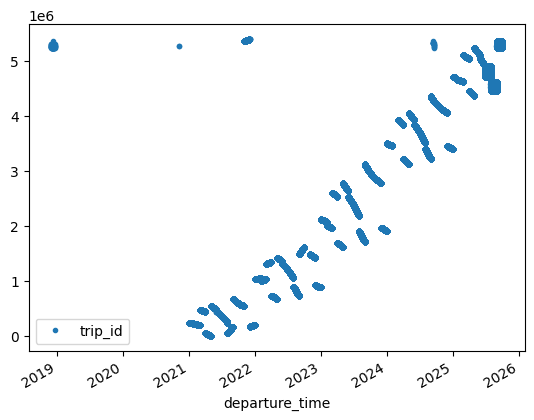

In [0]:
df_ts.plot(style=("."))

- Half of data between Dec 2022 to March 2023 isn't available. There are records, but values are empty
- There's no significant data beore 2021.
- There are gaps in some months, however, I find them negligible due to the overall data following a similar pattern, gaps not being at the same interval each year. We still have useful data.

In [0]:
# remove before 2021
df_ts = df_ts[df_ts.index >= "2021-01-01"]

In [0]:
# Resample Data
y_day = df_ts.resample("D").size()
y_week = df_ts.resample("W").size()
y_month = df_ts.resample("M").size()

/home/spark-b39123b9-efaa-4637-871c-e4/.ipykernel/51822/command-5241728766529353-2435006748:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_month = df_ts.resample("M").size()


<Axes: xlabel='departure_time'>

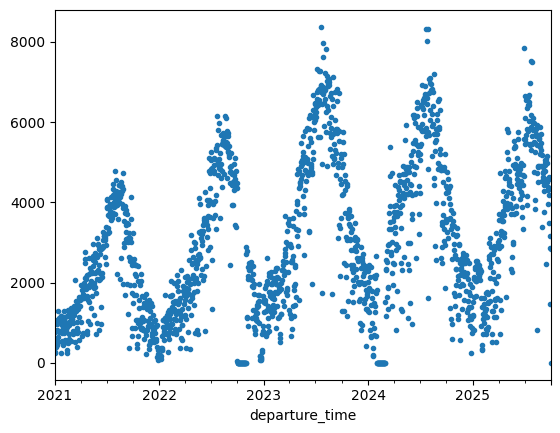

In [0]:
y_day.plot(style=".")

<Axes: xlabel='departure_time'>

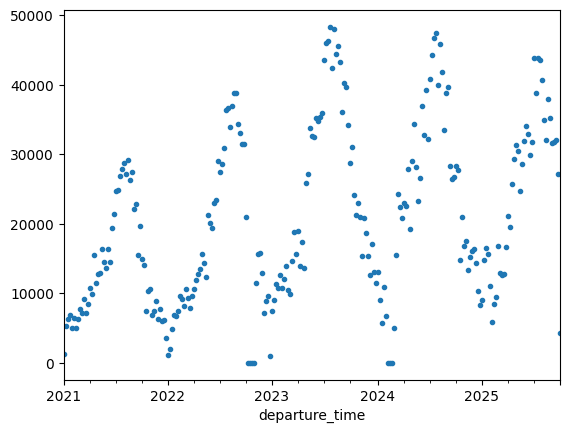

In [0]:
y_week.plot(style=".")

<Axes: xlabel='departure_time'>

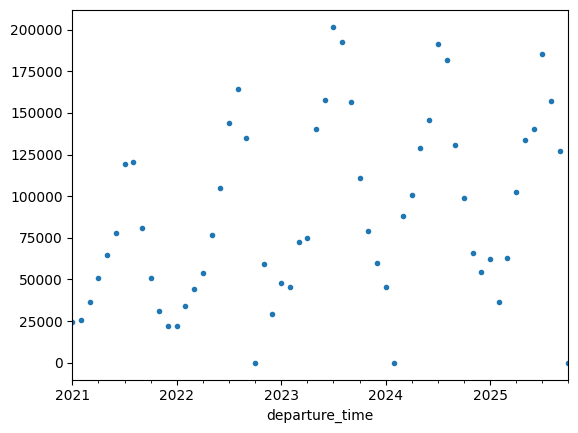

In [0]:
y_month.plot(style=".")

In [0]:
# Define Dickey Fuller Test for Stationary Check
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    print('\n')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    print('\n')
    
    if dfoutput['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has unit root and is non-stationary')


### weekly data

In [0]:
y_week_train = y_week[:'2024-12-31']
y_week_test = y_week['2025-01-01':]

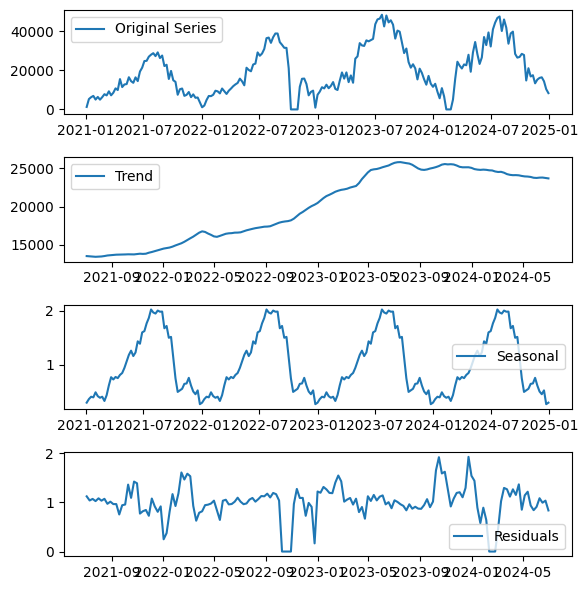

In [0]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Copy and create a new dataframe and replace zeros with ones (happens in 7 weeks)
## +1 added for operations required for the multiplicative model used in seasonal_decompose
y_week_train_decomposition = y_week_train.copy()
y_week_train_decomposition[y_week_train_decomposition == 0] = y_week_train_decomposition[y_week_train_decomposition == 0] + 1

result = seasonal_decompose(y_week_train_decomposition, model='multiplicative', period=52)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(y_week_train_decomposition, label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

<Axes: xlabel='departure_time'>

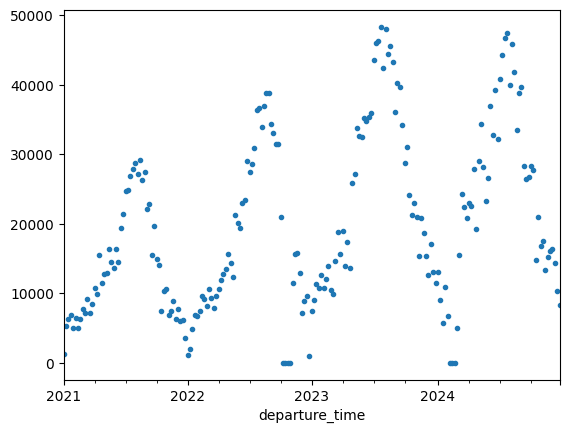

In [0]:
# Plot the original training data again
y_week_train.plot(style=".")

In [0]:
adf_test(y_week_train)

Results of Dickey-Fuller Test:


Test Statistic                  -2.679436
p-value                          0.077665
#Lags Used                       0.000000
Number of Observations Used    208.000000
Critical Value (1%)             -3.462186
Critical Value (5%)             -2.875538
Critical Value (10%)            -2.574231
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary


<Axes: xlabel='departure_time'>

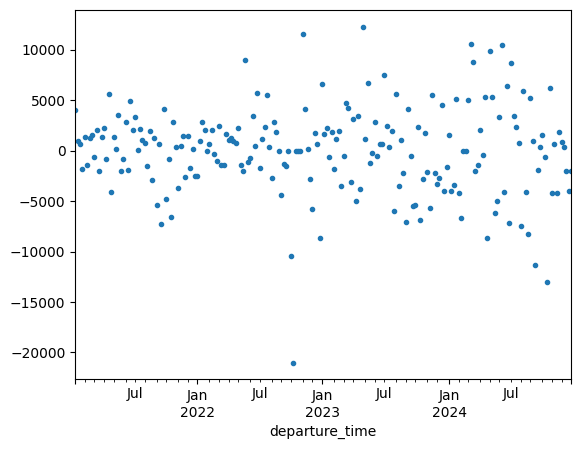

In [0]:
# Lets plot 1st Differenced Series
y_week_train_1st_diff = y_week_train.diff().dropna()
y_week_train_1st_diff.plot(style=".")

In [0]:
adf_test(y_week_train_1st_diff)

Results of Dickey-Fuller Test:


Test Statistic                -1.567594e+01
p-value                        1.492882e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary


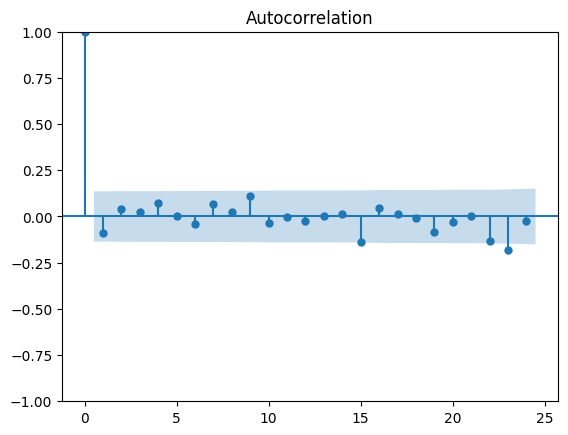

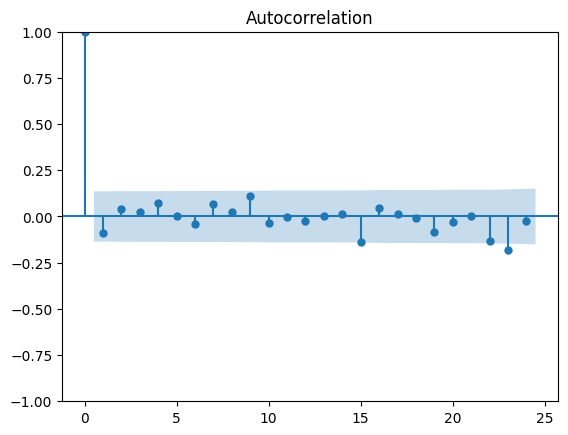

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_week_train_1st_diff)

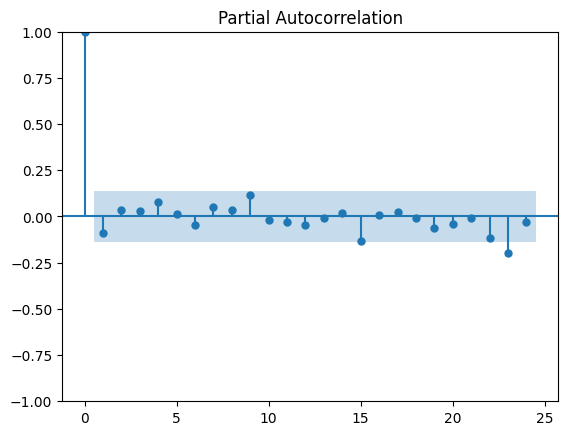

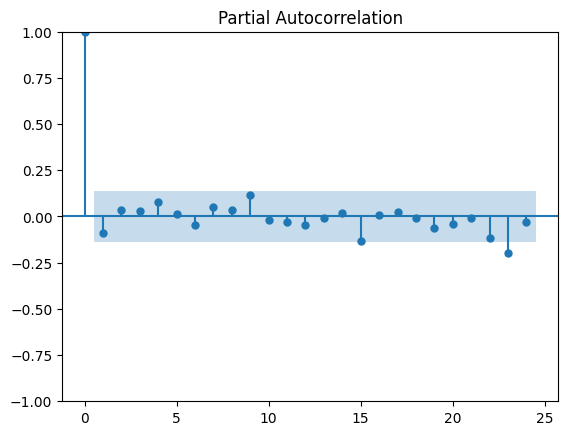

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(y_week_train_1st_diff)

In [0]:
## The complex model fails to finish in this environment.
### However, here's a documentation of a run and combination of separate checks results
#### see candidates and the run result below

# from pmdarima import auto_arima
# model = auto_arima(y_week_train,
#                       # Seasonality
#                       m=52,            
#                       seasonal=True,
#                       D=1,

#                       # Training Limits
#                       start_p=0, start_q=0,
#                       max_p=3, max_q=3,
#                       max_P=2, max_Q=2,
                      
#                       # Execution Settings
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())
# # candidates
# # ARIMA(2,1,2)(1,1,1)[52]              : AIC=3108.710, Time=60.72 sec - another run
# # ARIMA(1,1,1)(0,1,2)[52]              : AIC=3111.431, Time=40.11 sec
# # ARIMA(0,1,0)(0,1,0)[52]             : AIC=3164.616, Time=0.50 sec
# # Performing stepwise search to minimize aic
# #  ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=24.36 sec
# #  ARIMA(0,1,0)(0,1,0)[52]             : AIC=3164.616, Time=0.50 sec
# #  ARIMA(1,1,0)(1,1,0)[52]             : AIC=3121.517, Time=6.74 sec
# #  ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=20.56 sec
# #  ARIMA(1,1,0)(0,1,0)[52]             : AIC=3151.688, Time=0.47 sec
# #  ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=58.39 sec
# #  ARIMA(1,1,0)(1,1,1)[52]             : AIC=3113.727, Time=8.11 sec
# #  ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=18.94 sec
# #  ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=110.38 sec
# #  ARIMA(1,1,0)(1,1,2)[52]             : AIC=3115.097, Time=36.05 sec
# #  ARIMA(1,1,0)(0,1,2)[52]             : AIC=3113.165, Time=19.05 sec
# #  ARIMA(0,1,0)(0,1,2)[52]             : AIC=3117.779, Time=16.04 sec
# #  ARIMA(2,1,0)(0,1,2)[52]             : AIC=inf, Time=105.26 sec
# #  ARIMA(1,1,1)(0,1,2)[52]             : AIC=3111.431, Time=40.11 sec
# #  ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=38.13 sec
# #  ARIMA(1,1,1)(1,1,2)[52]             : AIC=inf, Time=133.62 sec
# #  ARIMA(1,1,1)(1,1,1)[52]             : AIC=inf, Time=48.84 sec
# #  ARIMA(0,1,1)(0,1,2)[52]             : AIC=3112.391, Time=18.85 sec
# #  ARIMA(2,1,1)(0,1,2)[52]             : AIC=inf, Time=112.06 sec

In [0]:
# Building the chosen model
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    y_week_train,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 52)
)

fitted_sarimax_model = sarimax_model.fit()
fitted_sarimax_model.summary()

/databricks/python_shell/lib/dbruntime/autoreload/discoverability/autoreload_discoverability_hook.py:72: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  return orig_warn(*args, **kwargs)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b39123b9-efaa-4637-871c-e47c4d75741c/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  209
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -1547.355
Date:                              Wed, 26 Nov 2025   AIC                           3108.710
Time:                                      23:22:24   BIC                           3130.059
Sample:                                  01-03-2021   HQIC                          3117.381
                                       - 12-29-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7035      1.103      0.638      0.524      -1.458       2.865
ar.L2          0.0753      0.821      0.092      0.927      -1.533       1.683
ma.L1         -1.0083      1.107     -0.911      0.363      -3.179       1.162
ma.L2          0.0290      1.067      0.027      0.978      -2.062       2.120
ar.S.L52      -0.2565      0.190     -1.349      0.177      -0.629       0.116
ma.S.L52      -0.4625      0.224     -2.061      0.039      -0.902      -0.023
sigma2      3.002e+07   2.59e-08   1.16e+15      0.000       3e+07       3e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                19.98
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.50
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+32. Standard errors may be unstable.
"""

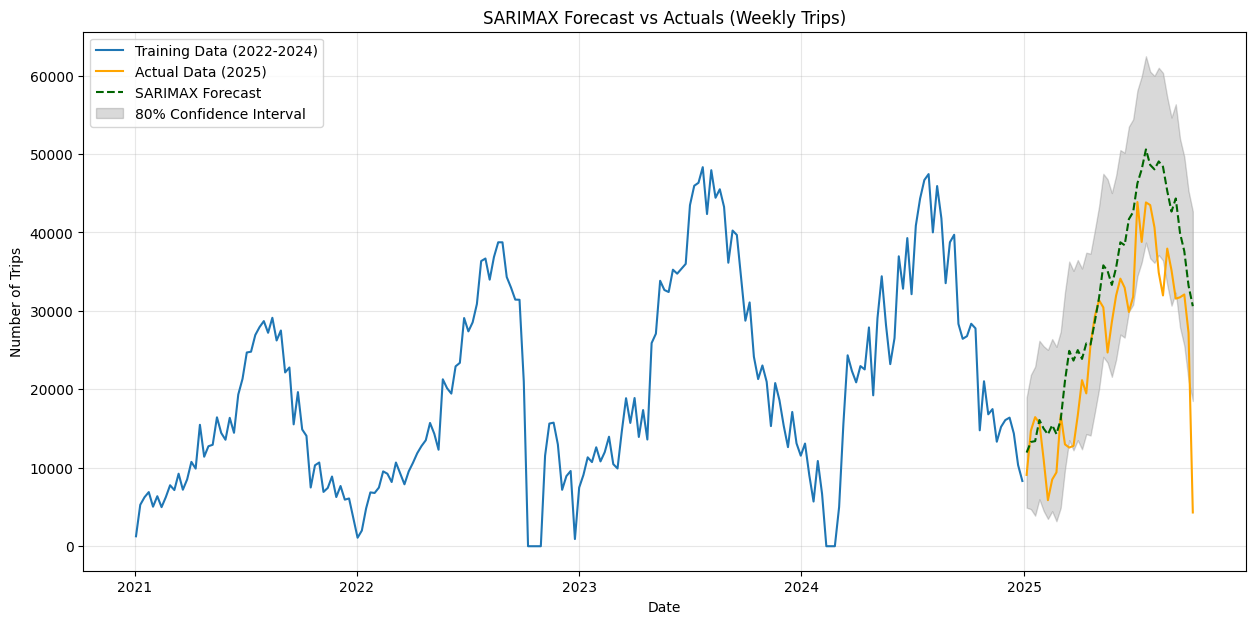

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecast_vs_actual(model, train_data, test_data):
    """
    Plots the Training data, Actual Test data, and the Model Forecast.
    """
    
    # 1. Get the Forecast for the length of the test set
    # get_forecast automatically handles the dates if your train data has a frequency
    n_periods = len(test_data)
    forecast_result = model.get_forecast(steps=n_periods)
    
    # Extract the Mean Forecast and Confidence Intervals
    forecast_series = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.20)
    
    # Ensure the index aligns (just in case statsmodels lost the frequency)
    # We force the forecast index to match the test data index
    forecast_series.index = test_data.index
    conf_int.index = test_data.index

    # 2. Plotting
    plt.figure(figsize=(15, 7))
    
    # A. Plot Training Data (The History)
    plt.plot(train_data.index, train_data, label='Training Data (2022-2024)', color='#1f76b4')
    
    # B. Plot Test Data (The Reality for 2025)
    plt.plot(test_data.index, test_data, label='Actual Data (2025)', color='orange')
    
    # C. Plot Forecast (The Prediction)
    plt.plot(forecast_series.index, forecast_series, label='SARIMAX Forecast', color='darkgreen', linestyle='--')
    
    # D. Plot Confidence Intervals (The Shaded Area)
    # iloc[:, 0] is lower bound, iloc[:, 1] is upper bound
    plt.fill_between(conf_int.index, 
                     conf_int.iloc[:, 0], 
                     conf_int.iloc[:, 1], 
                     color='k', alpha=0.15, label='80% Confidence Interval')

    plt.title("SARIMAX Forecast vs Actuals (Weekly Trips)")
    plt.xlabel("Date")
    plt.ylabel("Number of Trips")
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Run the function ---
plot_forecast_vs_actual(fitted_sarimax_model, y_week_train, y_week_test)